# Analysis of the Language for TRGs

## Dataset loading

In [ ]:
import os
import sys
import glob
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from joblib import Parallel
from matplotlib.ticker import PercentFormatter
from tqdm.notebook import tqdm
from collections import defaultdict
import scikit_posthocs as sp


# Workaround so we can re-use the metric functions
module_path = os.path.abspath(os.path.join("../"))
if module_path not in sys.path:
    sys.path.append(module_path)

import trgl.utils.metrics as metrics

In [5]:
sns.set(palette="pastel")
sns.set_style("whitegrid")
palette = sns.color_palette()

import matplotlib.pylab as pylab

params = {
    "legend.title_fontsize": "32",
    "legend.fontsize": "24",
    "axes.labelsize": "28",
    "axes.titlesize": "28",
    "xtick.labelsize": "22",
    "ytick.labelsize": "26",
}
pylab.rcParams.update(params)

In [ ]:
all_files = glob.glob(os.path.join("../logs/lightning_interactions/", "*.json"))
li = []
params = []
for filename in tqdm(all_files):
    split = filename.split("-")
    run_id = split[1]
    architecture = split[2]
    training_dataset = split[3]
    net_temporal = split[4].__contains__("True")
    loss_temporal = split[5].__contains__("True")
    purely_temporal = split[6].__contains__("True")
    attention_sender = split[7].__contains__("True")
    attention_receiver = split[8].__contains__("True")
    eval_dataset = split[9]
    params.append(
        [
            run_id,
            training_dataset,
            net_temporal,
            loss_temporal,
            purely_temporal,
            attention_sender,
            attention_receiver,
            eval_dataset,
        ]
    )
    df = pd.read_json(filename, orient="index")
    li.append(df)

In [ ]:
# This code is commented out not to bash WandB servers everytime we run analysis
# We run this only once and save to pickle

# import wandb
#
# wandb.login()
# api = wandb.Api(timeout=60)
#
# runs = api.runs("user/TRGL")
# summary_list, config_list, name_list = [], [], []
# for run in tqdm(runs):
#     summary_list.append(
#         run.history(
#             samples=400,
#         )
#     )
#
#     config_list.append({k: v for k, v in run.config.items()})
#
#     name_list.append(run.name.split("-")[1])
#
# runs_full_df = pd.DataFrame(
#     {
#         "summary": summary_list,
#         "config": config_list,
#         "name": name_list,
#     }
# )
#
# runs_full_df.to_pickle("./data/v4/runs_full_df.pickle")

In [ ]:
runs_full_df = pd.read_pickle("./data/v4/runs_full_df.pickle")
runs_full_df = runs_full_df[["summary", "config", "name"]]

In [ ]:
def df_stats(x: pd.DataFrame):
    # Some are empty, we'll drop them later
    x = x[x["val_acc"].notnull()]
    try:
        x["val_acc"].idxmax()
    except:
        return None
    max_acc_index = x["val_acc"].idxmax()
    over_75_index = x["val_acc"].ge(0.75).any() and x["val_acc"].ge(0.75).idxmax()
    over_85_index = x["val_acc"].ge(0.85).any() and x["val_acc"].ge(0.85).idxmax()
    end_acc_index = x["epoch"].idxmax()

    stats_dict = {
        "max_acc_epoch": x["epoch"][max_acc_index],
        "max_acc_value": x["val_acc"][max_acc_index],
        "over_75_epoch": x["epoch"][over_75_index] if over_75_index else -1,
        "over_75_value": x["val_acc"][over_75_index] if over_75_index else -1,
        "over_85_epoch": x["epoch"][over_85_index] if over_85_index else -1,
        "over_85_value": x["val_acc"][over_85_index] if over_85_index else -1,
        "end_acc_epoch": x["epoch"][end_acc_index],
        "end_acc_value": x["val_acc"][end_acc_index],
    }

    return stats_dict

In [ ]:
runs_full_df["summary"] = runs_full_df["summary"].apply(df_stats).dropna()
df_temp = pd.json_normalize(runs_full_df.pop("config"))
runs_full_df = runs_full_df.join(df_temp)
df_temp = pd.json_normalize(runs_full_df.pop("summary"))
runs_full_df = runs_full_df.join(df_temp)
runs_full_df = runs_full_df.set_index("name")

In [ ]:
matches = {
    f"match_{x}": {
        "run_id": params[x][0],
        "game_type": params[x][7],
        "training_dataset": params[x][1],
        "net_temporal": params[x][2],
        "loss_temporal": params[x][3],
        "purely_temporal": params[x][4],
        "attention_sender": params[x][5],
        "attention_receiver": params[x][6],
        "messages": {},
    }
    for x in range(len(li))
}

In [ ]:
for idx in tqdm(range(len(matches))):
    run_id = matches[f"match_{idx}"]["run_id"]
    matches[f"match_{idx}"]["temporal"] = runs_full_df.loc[f"{run_id}"]["temporal"][0]
    matches[f"match_{idx}"]["max_epochs"] = runs_full_df.loc[f"{run_id}"]["max_epochs"][
        0
    ]
    matches[f"match_{idx}"]["max_length"] = runs_full_df.loc[f"{run_id}"]["max_length"][
        0
    ]
    matches[f"match_{idx}"]["num_features"] = runs_full_df.loc[f"{run_id}"][
        "num_features"
    ][0]
    matches[f"match_{idx}"]["vocab_size"] = runs_full_df.loc[f"{run_id}"]["vocab_size"][
        0
    ]
    matches[f"match_{idx}"]["num_objects"] = runs_full_df.loc[f"{run_id}"][
        "num_objects"
    ][0]
    matches[f"match_{idx}"]["repeat_chance"] = runs_full_df.loc[f"{run_id}"][
        "repeat_chance"
    ][0]
    matches[f"match_{idx}"]["temporal_loss"] = runs_full_df.loc[f"{run_id}"][
        "temporal_loss"
    ][0]
    matches[f"match_{idx}"]["length_penalty"] = runs_full_df.loc[f"{run_id}"][
        "length_penalty"
    ][0]
    matches[f"match_{idx}"]["gs_temperature"] = runs_full_df.loc[f"{run_id}"][
        "gs_temperature"
    ][0]
    matches[f"match_{idx}"]["num_properties"] = runs_full_df.loc[f"{run_id}"][
        "num_properties"
    ][0]
    matches[f"match_{idx}"]["num_distractors"] = runs_full_df.loc[f"{run_id}"][
        "num_distractors"
    ][0]
    matches[f"match_{idx}"]["prev_horizon"] = runs_full_df.loc[f"{run_id}"][
        "prev_horizon"
    ][0]

## Compositionality Analysis

In [ ]:
# Function to be used for multiprocessing in cell below
def compute_compo_metrics(dataframe: pd.DataFrame):
    np_rng = np.random.default_rng()
    messages = np.array([msg for msg in dataframe["message"]], dtype=object)
    indices = np_rng.choice(
        len(messages), size=500 if len(messages) > 500 else len(messages), replace=False
    )
    messages = messages[indices].astype(int)
    # Get the corresponding meanings for randomly chosen messages
    meanings = np.array([objectx for objectx in dataframe["target"]])
    meanings = meanings[indices]
    # Calculate the compositionality metrics
    topsim = metrics.topographic_similarity(messages, meanings)
    posdis = metrics.posdis(messages, meanings)
    bosdis = metrics.bosdis(messages, meanings)
    return topsim, posdis, bosdis

In [ ]:
# For 8640 Files on 2x 32 core Gold 6130 - ~25 mins
start_time = time.perf_counter()

results = Parallel(n_jobs=os.cpu_count(), verbose=10)(
    (compute_compo_metrics, (df,), {}) for df in li
)

for x in range(len(li)):
    matches[f"match_{x}"]["topsim"] = results[x][0][0]
    matches[f"match_{x}"]["posdis"] = results[x][1]
    matches[f"match_{x}"]["bosdis"] = results[x][2]

finish_time = time.perf_counter()
print(f"Computing metrics finished in {finish_time-start_time} seconds")
del results

## Strategy analysis

In [ ]:
# Function to be used for multiprocessing in cell below
def process_dataframe_messages(match_dataframe: pd.DataFrame, prev_horizon: int):
    msg_stats = {
        msg: {
            "count": match_dataframe["message"].astype(str).value_counts()[msg],
            "correct": 0,
            "objects_referred_to": 0,
        }
        for msg in match_dataframe["message"].astype(str).unique()
    }

    for msg in match_dataframe["message"].astype(str).unique():
        for x in range(1, prev_horizon + 1):
            msg_stats[msg].update(
                {
                    f"same_as_previous_obj_h{x}": 0,
                    f"same_as_previous_obj_correct_h{x}": 0,
                }
            )

    match_dataframe_numpy = match_dataframe.to_numpy()

    # Calculate stats per row
    for row in range(1, match_dataframe.shape[0]):
        # Times message made the receiver guess correctly
        if np.array_equal(
            match_dataframe_numpy[row][2],
            match_dataframe_numpy[row][4],
        ):
            msg_stats[f"{match_dataframe_numpy[row][1]}"]["correct"] += 1

        # Number of times the message has referred to this object:
        if (
            f"{match_dataframe_numpy[row][0][match_dataframe_numpy[row][4]]}"
            in msg_stats[f"{match_dataframe_numpy[row][1]}"]
        ):
            msg_stats[f"{match_dataframe_numpy[row][1]}"][
                f"{match_dataframe_numpy[row][0][match_dataframe_numpy[row][4]]}"
            ] += 1
        else:
            msg_stats[f"{match_dataframe_numpy[row][1]}"][
                f"{match_dataframe_numpy[row][0][match_dataframe_numpy[row][4]]}"
            ] = 1
            msg_stats[f"{match_dataframe_numpy[row][1]}"]["objects_referred_to"] += 1

        # Times that the object was the same as the previous object and also when message was correct
        for horizon in range(1, prev_horizon + 1):
            if np.array_equal(
                match_dataframe_numpy[row][0][match_dataframe_numpy[row][4]],
                match_dataframe_numpy[row - horizon][0][
                    match_dataframe_numpy[row - horizon][4]
                ],
            ):
                msg_stats[f"{match_dataframe_numpy[row][1]}"][
                    f"same_as_previous_obj_h{horizon}"
                ] += 1
                if match_dataframe_numpy[row][2] == match_dataframe_numpy[row][4]:
                    msg_stats[f"{match_dataframe_numpy[row][1]}"][
                        f"same_as_previous_obj_correct_h{horizon}"
                    ] += 1

    # Calculate the averages and percentages
    for msg in msg_stats:
        if msg_stats[msg]["count"] > 0:
            msg_stats[msg]["percentage_correct"] = round(
                msg_stats[msg]["correct"] / msg_stats[msg]["count"], 3
            )

            for horizon in range(1, prev_horizon + 1):
                if msg_stats[msg][f"same_as_previous_obj_h{horizon}"] != 0:
                    msg_stats[msg][f"percentage_correct_prev_h{horizon}"] = round(
                        msg_stats[msg][f"same_as_previous_obj_correct_h{horizon}"]
                        / msg_stats[msg][f"same_as_previous_obj_h{horizon}"],
                        3,
                    )
                    msg_stats[msg][f"prev_use_percentage_h{horizon}"] = round(
                        msg_stats[msg][f"same_as_previous_obj_h{horizon}"]
                        / msg_stats[msg]["count"],
                        3,
                    )
                else:
                    msg_stats[msg][f"percentage_correct_prev_h{horizon}"] = 0
                    msg_stats[msg][f"prev_use_percentage_h{horizon}"] = 0

                if msg_stats[msg]["correct"] != 0:
                    msg_stats[msg][f"prev_as_perc_of_correct_h{horizon}"] = round(
                        msg_stats[msg][f"same_as_previous_obj_correct_h{horizon}"]
                        / msg_stats[msg]["correct"],
                        3,
                    )
                else:
                    msg_stats[msg][f"prev_as_perc_of_correct_h{horizon}"] = 0

    return pd.DataFrame(msg_stats)

In [ ]:
# Takes about 45 minutes on 2x 32 core Gold 6130 with 8640 files
start_time = time.perf_counter()

results = Parallel(n_jobs=os.cpu_count(), verbose=10)(
    (
        process_dataframe_messages,
        (
            li[x],
            matches[f"match_{x}"]["prev_horizon"],
        ),
        {},
    )
    for x in range(len(li))
)

for x in range(len(li)):
    matches[f"match_{x}"]["messages"] = results[x]

finish_time = time.perf_counter()
print(f"Computing strategy stats finished in {finish_time-start_time} seconds")
del results

In [ ]:
# More metrics
match_count = 0
for match in tqdm(li):
    uniq_dict = {}
    targets = match["target_id"].to_numpy()
    object_count = 0
    repeats = 0
    prev_target = 0

    for exchange in match["objects"].to_numpy():
        if f"{exchange[targets[object_count]]}" not in uniq_dict:
            uniq_dict[f"{exchange[targets[object_count]]}"] = 1
        else:
            uniq_dict[f"{exchange[targets[object_count]]}"] += 1
        object_count += 1

    for target in match["target"]:
        if f"{prev_target}" == f"{target}":
            repeats += 1
        prev_target = target

    matches[f"match_{match_count}"]["unique_objects"] = len(uniq_dict.keys())
    matches[f"match_{match_count}"]["repeats"] = repeats
    object_accuracy = (match["guess"] == match["target_id"]).sum() / match.__len__()
    matches[f"match_{match_count}"]["object_accuracy"] = object_accuracy
    temporal_accuracy = (
        match["temporal_prediction"] == match["temporal_label"]
    ).sum() / match.__len__()
    matches[f"match_{match_count}"]["temporal_accuracy"] = temporal_accuracy
    match_count += 1

In [ ]:
# Label the matches properly
for x in range(len(matches)):
    game_label = None
    dataset_label = None
    net_label = None
    game_labels = [
        "Always Same",
        "Never Same",
        "RG",
        "RG Hard",
        "TRG Hard",
        "TRG",
    ]
    if matches[f"match_{x}"]["game_type"] == "analysis_always_same":
        game_label = game_labels[0]
    if matches[f"match_{x}"]["game_type"] == "analysis_never_same":
        game_label = game_labels[1]
    if matches[f"match_{x}"]["game_type"] == "rg_classic":
        game_label = game_labels[2]
    if matches[f"match_{x}"]["game_type"] == "rg_hard":
        game_label = game_labels[3]
    if matches[f"match_{x}"]["game_type"] == "trg_hard":
        game_label = game_labels[4]
    if matches[f"match_{x}"]["game_type"] == "trg_previous":
        game_label = game_labels[5]

    if matches[f"match_{x}"]["training_dataset"] == "train_regular":
        dataset_label = "Regular"
    if matches[f"match_{x}"]["training_dataset"] == "train_temporal":
        dataset_label = "Temporal"

    if matches[f"match_{x}"]["net_temporal"]:
        if matches[f"match_{x}"]["loss_temporal"]:
            net_label = "Temporal"
        else:
            net_label = "Temporal-NL"
    else:
        net_label = "Non-Temporal"

    matches[f"match_{x}"]["human_label"] = f"{game_label} {net_label} {dataset_label}"

In [ ]:
matches_df = pd.DataFrame(matches)
matches_df = matches_df.T

In [ ]:
start_time = time.perf_counter()
matches_df["messages"] = matches_df["messages"].apply(lambda x: x.fillna(0))
finish_time = time.perf_counter()
print(f"Cleaning NaNs finished in {finish_time-start_time} seconds")

In [ ]:
def get_h_vals(x: pd.DataFrame):
    try:
        return x.T[f"prev_use_percentage_h{horizon}"].values
    except KeyError:
        return 0

In [ ]:
# move prev use percentage up a level
# Get the maximum horizon for each match
max_horizons = matches_df["prev_horizon"].values

# Create an empty list to store the percentage values for each horizon
perc = []

# Extract the percentage values for each horizon using NumPy indexing
for horizon in range(1, np.max(max_horizons) + 1):
    perc.append(matches_df["messages"].apply(lambda x: get_h_vals(x)))

# Convert the list of arrays to a dataframe and concatenate it with the original matches_df
perc_df = pd.DataFrame(
    np.array(perc).T,
    columns=[
        f"prev_use_percentage_h{horizon}"
        for horizon in range(1, np.max(max_horizons) + 1)
    ],
)
perc_df = perc_df.set_index(matches_df.index)
matches_df = pd.concat([matches_df, perc_df], axis=1)

In [ ]:
perc = []
for i in tqdm(range(len(matches_df["messages"]))):
    perc.append(matches_df["messages"][i].T["count"].values)

matches_df["counts"] = perc

In [ ]:
matches_df["objects_referred_to"] = 0
matches_df["objects_referred_to"] = matches_df["objects_referred_to"].astype(object)
matches_df["percentage_correct"] = 0
matches_df["percentage_correct"] = matches_df["percentage_correct"].astype(object)

for i, row in tqdm(matches_df.iterrows(), total=len(matches_df)):
    max_horizon = row["prev_horizon"]
    for horizon in range(1, max_horizon + 1):
        matches_df[f"percentage_correct_prev_h{horizon}"] = 0
        matches_df[f"percentage_correct_prev_h{horizon}"] = matches_df[
            f"percentage_correct_prev_h{horizon}"
        ].astype(object)

In [ ]:
for i, row in tqdm(matches_df.iterrows(), total=len(matches_df)):
    max_horizon = row["prev_horizon"]
    count_matrix = row["counts"] >= 5
    perc1_dict = {}
    perc2_dict = {}
    perc3_dict = {}
    for horizon in range(1, max_horizon + 1):
        usage_matrix = (row[f"prev_use_percentage_h{horizon}"] == 1.0) * count_matrix
        perc1_dict[f"percentage_correct_prev_h{horizon}"] = (
            row["messages"].T[f"percentage_correct_prev_h{horizon}"].values
            * usage_matrix
            * 100
        )
        perc2_dict["objects_referred_to"] = (
            row["messages"].T["objects_referred_to"].values * count_matrix
        )
        perc3_dict["percentage_correct"] = (
            row["messages"].T["percentage_correct"].values * 100
        )

    for key in list(perc1_dict.keys()):
        matches_df.at[i, key] = np.array(list(perc1_dict[key]))
    matches_df.at[i, "objects_referred_to"] = np.array(
        list(perc2_dict.values())
    ).flatten()
    matches_df.at[i, "percentage_correct"] = np.array(
        list(perc3_dict.values())
    ).flatten()

In [ ]:
# Convert to %
max_horizons = matches_df["prev_horizon"].values
for horizon in range(1, np.max(max_horizons) + 1):
    matches_df[f"prev_use_percentage_h{horizon}"] *= 100

matches_df["repeat_chance"] *= 100
matches_df["object_accuracy"] *= 100
matches_df["temporal_accuracy"] *= 100

matches_df = matches_df.sort_values(
    ["run_id", "net_temporal", "loss_temporal", "training_dataset", "game_type"]
)

In [ ]:
# Save to pickle as computation takes a very long time.
matches_df.to_pickle("./data/v4/matches_df.pickle")

In [ ]:
# Read from pickle - should be no difference and progress saved!
matches_df = pd.read_pickle("./data/v4/matches_df.pickle")

## Graphs

In [ ]:
base_data = matches_df[
    (matches_df["attention_sender"] == False)
    & (matches_df["attention_receiver"] == False)
    & (matches_df["purely_temporal"] == False)
    & (matches_df["net_temporal"] == False)
]
temporal_data = matches_df[
    (matches_df["attention_sender"] == False)
    & (matches_df["attention_receiver"] == False)
    & (matches_df["purely_temporal"] == True)
]
temporalr_data = matches_df[
    (matches_df["attention_sender"] == False)
    & (matches_df["attention_receiver"] == False)
    & (matches_df["purely_temporal"] == False)
    & (matches_df["net_temporal"] == True)
]
attention_data = matches_df[
    (matches_df["attention_sender"] == True)
    & (matches_df["attention_receiver"] == True)
    & (matches_df["net_temporal"] == False)
]

label_list = [
    [
        "Base trained on RGs",
        "Base trained on TRGs",
        "Base+L trained on RGs",
        "Base+L trained on TRGs",
    ],
    [
        "Temporal trained on RGs",
        "Temporal trained on TRGs",
        "Temporal+L trained on RGs",
        "Temporal+L trained on TRGs",
    ],
    [
        "TemporalR trained on RGs",
        "TemporalR trained on TRGs",
        "TemporalR+L trained on RGs",
        "TemporalR+L trained on TRGs",
    ],
    [
        "Attention trained on RGs",
        "Attention trained on TRGs",
        "Attention+L trained on RGs",
        "Attention+L trained on TRGs",
    ],
]

In [ ]:
for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.boxplot(
        data=data.sort_values(by="game_type"),
        y="object_accuracy",
        x="game_type",
        hue=matches_df[["loss_temporal", "training_dataset"]].apply(tuple, axis=1),
        order=[
            "analysis_always_same",
            "analysis_never_same",
            "rg_classic",
            "rg_hard",
            "trg_previous",
            "trg_hard",
        ],
        ax=ax,
    ).set(
        xlabel="Validation dataset",
        ylabel="Accuracy",
        xticklabels=[
            "Always Same",
            "Never Same",
            "RG",
            "RG Hard",
            "TRG",
            "TRG Hard",
        ],
    )
    labels = label_list[i]

    ax.yaxis.set_major_formatter(PercentFormatter(decimals=0))
    hatches = ["///", "..", "xx", "OO"]
    hatches = sorted(hatches * 6)
    # noinspection PyUnresolvedReferences
    patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    # iterate through the patches for each subplot
    for patch, hatch in zip(patches, hatches):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor("none")
    h, _ = ax.get_legend_handles_labels()
    l = ax.legend(
        h,
        labels,
        title="Network Type",
        ncols=2,
        bbox_to_anchor=(0.45, 1.35),
        loc="upper center",
        labelspacing=0.35,
        columnspacing=1,
        handletextpad=0.7,
    )
    for lp, hatch in zip(l.get_patches(), sorted(["///", "..", "xx", "OO"])):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")
    plt.savefig(f"accuracy_eval_{i}.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.boxplot(
        data=data,
        y="topsim",
        x="game_type",
        hue=matches_df[["loss_temporal", "training_dataset"]].apply(tuple, axis=1),
        order=[
            "analysis_always_same",
            "analysis_never_same",
            "rg_classic",
            "rg_hard",
            "trg_previous",
            "trg_hard",
        ],
        ax=ax,
    ).set(
        xlabel="Validation dataset",
        ylabel="Topographic similarity",
        xticklabels=[
            "Always Same",
            "Never Same",
            "RG",
            "RG Hard",
            "TRG",
            "TRG Hard",
        ],
    )
    labels = label_list[i]

    hatches = ["///", "..", "xx", "OO"]
    hatches = sorted(hatches * 6)
    # noinspection PyUnresolvedReferences
    patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    # iterate through the patches for each subplot
    for patch, hatch in zip(patches, hatches):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor("none")
    h, _ = ax.get_legend_handles_labels()
    l = ax.legend(
        h,
        labels,
        title="Network Type",
        ncols=2,
        bbox_to_anchor=(0.45, 1.35),
        loc="upper center",
        labelspacing=0.35,
        columnspacing=1,
        handletextpad=0.7,
    )
    for lp, hatch in zip(l.get_patches(), sorted(["///", "..", "xx", "OO"])):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")
    plt.savefig(f"topsim_eval_{i}.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.boxplot(
        data=data,
        y="posdis",
        x="game_type",
        hue=matches_df[["loss_temporal", "training_dataset"]].apply(tuple, axis=1),
        order=[
            "analysis_always_same",
            "analysis_never_same",
            "rg_classic",
            "rg_hard",
            "trg_previous",
            "trg_hard",
        ],
        ax=ax,
    ).set(
        xlabel="Validation dataset",
        ylabel="Positional Disentanglement",
        xticklabels=[
            "Always Same",
            "Never Same",
            "RG",
            "RG Hard",
            "TRG",
            "TRG Hard",
        ],
    )
    labels = label_list[i]

    hatches = ["///", "..", "xx", "OO"]
    hatches = sorted(hatches * 6)
    # noinspection PyUnresolvedReferences
    patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    # iterate through the patches for each subplot
    for patch, hatch in zip(patches, hatches):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor("none")
    h, _ = ax.get_legend_handles_labels()
    l = ax.legend(
        h,
        labels,
        title="Network Type",
        ncols=2,
        bbox_to_anchor=(0.45, 1.35),
        loc="upper center",
        labelspacing=0.35,
        columnspacing=1,
        handletextpad=0.7,
    )
    for lp, hatch in zip(l.get_patches(), sorted(["///", "..", "xx", "OO"])):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")
    plt.savefig(f"posdis_eval_{i}.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.boxplot(
        data=data,
        y="bosdis",
        x="game_type",
        hue=matches_df[["loss_temporal", "training_dataset"]].apply(tuple, axis=1),
        order=[
            "analysis_always_same",
            "analysis_never_same",
            "rg_classic",
            "rg_hard",
            "trg_previous",
            "trg_hard",
        ],
        ax=ax,
    ).set(
        xlabel="Validation dataset",
        ylabel="Bag-of-words disentanglement",
        xticklabels=[
            "Always Same",
            "Never Same",
            "RG",
            "RG Hard",
            "TRG",
            "TRG Hard",
        ],
    )
    labels = label_list[i]

    hatches = ["///", "..", "xx", "OO"]
    hatches = sorted(hatches * 6)
    # noinspection PyUnresolvedReferences
    patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    # iterate through the patches for each subplot
    for patch, hatch in zip(patches, hatches):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor("none")
    h, _ = ax.get_legend_handles_labels()
    l = ax.legend(
        h,
        labels,
        title="Network Type",
        ncols=2,
        bbox_to_anchor=(0.45, 1.35),
        loc="upper center",
        labelspacing=0.35,
        columnspacing=1,
        handletextpad=0.7,
    )
    for lp, hatch in zip(l.get_patches(), sorted(["///", "..", "xx", "OO"])):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")
    plt.savefig(f"bosdis_eval_{i}.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    fig, ax = plt.subplots(figsize=(16, 8))
    fig_df = data.explode(f"prev_use_percentage_h4")
    fig_df[f"prev_use_percentage_h4"] = fig_df[f"prev_use_percentage_h4"].astype(float)
    sns.violinplot(
        data=fig_df,
        y=f"prev_use_percentage_h4",
        x="game_type",
        ax=ax,
        hue=fig_df[["loss_temporal", "training_dataset"]].apply(tuple, axis=1),
        order=[
            "analysis_always_same",
            "analysis_never_same",
            "rg_classic",
            "rg_hard",
            "trg_previous",
            "trg_hard",
        ],
        cut=0,
    ).set(
        xlabel="Validation dataset",
        ylabel=r"$M_{\ominus^4}$",
        xticklabels=[
            "Always Same",
            "Never Same",
            "RG",
            "RG Hard",
            "TRG",
            "TRG Hard",
        ],
    )
    labels = label_list[i]

    hatches = ["//", "..", "xx", "OO"]
    patches = [
        patch
        for patch in ax.get_children()
        if type(patch) == mpl.collections.PolyCollection
    ]
    # the number of patches should be evenly divisible by the number of hatches
    # For base there is special case
    # As the hatches dont display nicely
    if i == 0:
        h = ["//", "xx", "OO", "//", "..", "xx", "OO", "//", "..", "xx", "OO"]
    else:
        h = hatches * (len(patches) // len(hatches))
    # iterate through the patches for each subplot
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor("none")
    ax.yaxis.set_major_formatter(PercentFormatter())

    h, _ = ax.get_legend_handles_labels()
    l = ax.legend(
        h,
        labels,
        title="Network Type",
        ncols=2,
        bbox_to_anchor=(0.43, 1.5),
        loc="upper center",
        labelspacing=0.35,
        columnspacing=1,
        handletextpad=0.7,
    )
    for lp, hatch in zip(l.get_patches(), hatches):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")

    plt.savefig(f"prev_usage_h4_{i}_s_f.png", bbox_inches="tight", pad_inches=0)
    plt.savefig(f"prev_usage_h4_{i}_s_f.pdf", bbox_inches="tight", pad_inches=0)
    plt.show()

In [ ]:
for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    fig, axes = plt.subplots(figsize=(34, 34), nrows=4, ncols=2)
    axes = axes.reshape(-1)
    for horizon in range(1, 9):
        fig_df = data.explode(f"prev_use_percentage_h{horizon}")
        fig_df[f"prev_use_percentage_h{horizon}"] = fig_df[
            f"prev_use_percentage_h{horizon}"
        ].astype(float)
        sns.violinplot(
            data=fig_df,
            y=f"prev_use_percentage_h{horizon}",
            x="game_type",
            ax=axes[horizon - 1],
            hue=fig_df[["loss_temporal", "training_dataset"]].apply(tuple, axis=1),
            order=[
                "analysis_always_same",
                "analysis_never_same",
                "rg_classic",
                "rg_hard",
                "trg_previous",
                "trg_hard",
            ],
            cut=0,
        ).set(
            xlabel="Validation dataset",
            ylabel=f"$M_{{\ominus^{horizon}}}$",
            xticklabels=[
                "Always Same",
                "Never Same",
                "RG",
                "RG Hard",
                "TRG",
                "TRG Hard",
            ],
        )
        labels = label_list[i]
        hatches = ["//", "..", "xx", "OO"]
        patches = [
            patch
            for patch in axes[horizon - 1].get_children()
            if type(patch) == mpl.collections.PolyCollection
        ]
        # the number of patches should be evenly divisible by the number of hatches
        h = hatches * (len(patches) // len(hatches))
        # Done manually as the polycollection not present for first four...
        h = [
            "\\\\",
            "**",
            "||",
            "--",
            "//",
            "..",
            "xx",
            "OO",
            "\\\\",
            "**",
            "||",
            "--",
            "//",
            "..",
            "xx",
            "OO",
            "\\\\",
            "**",
            "||",
            "--",
        ]
        # iterate through the patches for each subplot
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            fc = patch.get_facecolor()
            patch.set_edgecolor(fc)
            patch.set_facecolor("none")
        axes[horizon - 1].yaxis.set_major_formatter(PercentFormatter())
        axes[horizon - 1].get_legend().remove()

    h, _ = axes[0].get_legend_handles_labels()
    l = axes[0].legend(
        h,
        labels,
        title="Network Type",
        ncols=2,
        bbox_to_anchor=(1.0, 1.55),
        loc="upper center",
    )
    for lp, hatch in zip(l.get_patches(), hatches):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")

    plt.savefig(f"prev_usage_h8_{i}_f.png", bbox_inches="tight", pad_inches=0)
    plt.savefig(f"prev_usage_h8_{i}_f.pdf", bbox_inches="tight", pad_inches=0)
    plt.show()

In [ ]:
for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    # We check this is truly empty in later code, but here trying to plot empty data will error out
    if i == 0:
        continue
    fig, ax = plt.subplots(figsize=(14, 8))
    fig_df = data[
        (data["game_type"] != "analysis_never_same")
        & (data["game_type"] != "rg_classic")
        & (data["game_type"] != "rg_hard")
    ].explode(["percentage_correct", "prev_use_percentage_h4"])
    fig_df[f"percentage_correct"] = fig_df[f"percentage_correct"].astype(float)
    fig_df = fig_df.loc[fig_df["prev_use_percentage_h4"] >= 100]
    sns.violinplot(
        data=fig_df,
        y=f"percentage_correct",
        x="game_type",
        ax=ax,
        hue=fig_df[["loss_temporal", "training_dataset"]].apply(tuple, axis=1),
        order=[
            "analysis_always_same",
            "analysis_never_same",
            "rg_classic",
            "rg_hard",
            "trg_previous",
            "trg_hard",
        ],
        cut=0,
    ).set(
        xlabel="Validation dataset",
        ylabel=r"% Correct for $\ominus^4$",
        xticklabels=[
            "Always Same",
            # "Never Same",
            # "RG",
            # "RG Hard",
            "TRG",
            "TRG Hard",
        ],
    )
    labels = label_list[i]
    hatches = ["//", "..", "xx", "OO"]  # , "\\\\", "**", "||", "--"]
    patches = [
        patch
        for patch in ax.get_children()
        if type(patch) == mpl.collections.PolyCollection
    ]
    # the number of patches should be evenly divisible by the number of hatches
    h = hatches * (len(patches) // len(hatches))
    # iterate through the patches for each subplot
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor("none")

    ax.yaxis.set_major_formatter(PercentFormatter())

    h, _ = ax.get_legend_handles_labels()
    l = ax.legend(
        h,
        labels,
        title="Network Type",
        ncols=2,
        bbox_to_anchor=(0.43, 1.35),
        loc="upper center",
        labelspacing=0.35,
        columnspacing=1,
        handletextpad=0.7,
    )
    for lp, hatch in zip(l.get_patches(), hatches):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")

    plt.savefig(f"prev_correct_h4_s_{i}.png", bbox_inches="tight", pad_inches=0)
    plt.savefig(f"prev_correct_h4_s_{i}.pdf", bbox_inches="tight", pad_inches=0)
    plt.show()

In [ ]:
for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    # We check this is truly empty in later code, but here trying to plot empty data will error out
    if i == 0:
        continue
    fig, axes = plt.subplots(figsize=(28, 32), nrows=4, ncols=2)
    axes = axes.reshape(-1)
    for horizon in range(1, 9):
        fig_df = data[data["prev_horizon"] == 8].explode(
            ["percentage_correct", f"prev_use_percentage_h{horizon}"]
        )
        fig_df[f"percentage_correct"] = fig_df[f"percentage_correct"].astype(float)
        fig_df = fig_df[fig_df[f"prev_use_percentage_h{horizon}"] >= 100]
        sns.violinplot(
            data=fig_df,
            y=f"percentage_correct",
            x="game_type",
            ax=axes[horizon - 1],
            hue=fig_df[["loss_temporal", "training_dataset"]].apply(tuple, axis=1),
            order=[
                "analysis_always_same",
                "analysis_never_same",
                "rg_classic",
                "rg_hard",
                "trg_previous",
                "trg_hard",
            ],
            cut=0,
        ).set(
            xlabel="Validation dataset",
            ylabel=f"% Correct for $\ominus^{horizon}$",
            xticklabels=[
                "Always Same",
                # "Never Same",
                # "RG",
                # "RG Hard",
                "TRG Hard",
                "TRG",
            ],
        )
        labels = label_list[i]
        hatches = ["//", "..", "xx", "OO"]  # , "\\\\", "**", "||", "--"]
        patches = [
            patch
            for patch in axes[horizon - 1].get_children()
            if type(patch) == mpl.collections.PolyCollection
        ]
        # the number of patches should be evenly divisible by the number of hatches
        h = hatches * (len(patches) // len(hatches))
        # iterate through the patches for each subplot
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            fc = patch.get_facecolor()
            patch.set_edgecolor(fc)
            patch.set_facecolor("none")
        axes[horizon - 1].set_ylim([0, 100])
        axes[horizon - 1].yaxis.set_major_formatter(PercentFormatter(decimals=0))
        axes[horizon - 1].get_legend().remove()

    h, _ = axes[0].get_legend_handles_labels()
    l = axes[0].legend(
        h,
        labels,
        title="Network Type",
        ncols=2,
        bbox_to_anchor=(1.0, 1.43),
        loc="upper center",
        labelspacing=0.35,
        columnspacing=1,
        handletextpad=0.7,
    )
    for lp, hatch in zip(l.get_patches(), hatches):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")

    plt.savefig(f"prev_correct_h8_{i}.png", bbox_inches="tight", pad_inches=0)
    plt.savefig(f"prev_correct_h8_{i}.pdf", bbox_inches="tight", pad_inches=0)
    plt.show()

In [ ]:
for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    fig, ax = plt.subplots(figsize=(15, 8))
    fig_df = data.explode("percentage_correct")
    sns.boxplot(
        data=fig_df,
        y="percentage_correct",
        x="game_type",
        hue=fig_df[["loss_temporal", "training_dataset"]].apply(tuple, axis=1),
        order=[
            "analysis_always_same",
            "analysis_never_same",
            "rg_classic",
            "rg_hard",
            "trg_previous",
            "trg_hard",
        ],
    ).set(
        xlabel="Validation dataset",
        ylabel="% Correct for all messages",
        xticklabels=[
            "Always Same",
            "Never Same",
            "RG",
            "RG Hard",
            "TRG Hard",
            "TRG",
        ],
    )
    labels = label_list[i]
    hatches = ["//", "..", "xx", "OO"]
    patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    # the number of patches should be evenly divisible by the number of hatches
    h = hatches * (len(patches) // len(hatches))
    # iterate through the patches for each subplot
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor("none")
    h, _ = ax.get_legend_handles_labels()
    l = ax.legend(
        h,
        labels,
        title="Network Type",
        ncols=2,
        bbox_to_anchor=(0.5, 1.35),
        loc="upper center",
        labelspacing=0.35,
        columnspacing=1,
        handletextpad=0.7,
    )
    for lp, hatch in zip(l.get_patches(), hatches):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")
    ax.yaxis.set_major_formatter(PercentFormatter())
    plt.savefig(f"overall_correct_{i}.png", bbox_inches="tight", pad_inches=0)
    plt.savefig(f"overall_correct_{i}.pdf", bbox_inches="tight", pad_inches=0)
    plt.show()

In [2]:
from trgl.dataset import TemporalDataset

# Gather these values over an even larger sample size
master_cnt = []
for dataset_type in tqdm(["rg_classic", "rg_hard", "trg_previous", "trg_hard"]):
    type_cnt = []
    for i in tqdm(range(1000)):
        dataset = TemporalDataset(
            num_objects=1000,
            num_features=8,
            num_properties=8,
            dataset_type=dataset_type,
        )
        cnt = dataset.aux_stats["repetitions"]
        # Create percentage for nicer display
        type_cnt.append(cnt / 10)
    master_cnt.append(type_cnt)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/olipinski/anaconda3/envs/trgl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/olipinski/anaconda3/envs/trgl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/olipinski/anaconda3/envs/trgl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/olipinski/anaconda3/envs/trgl/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

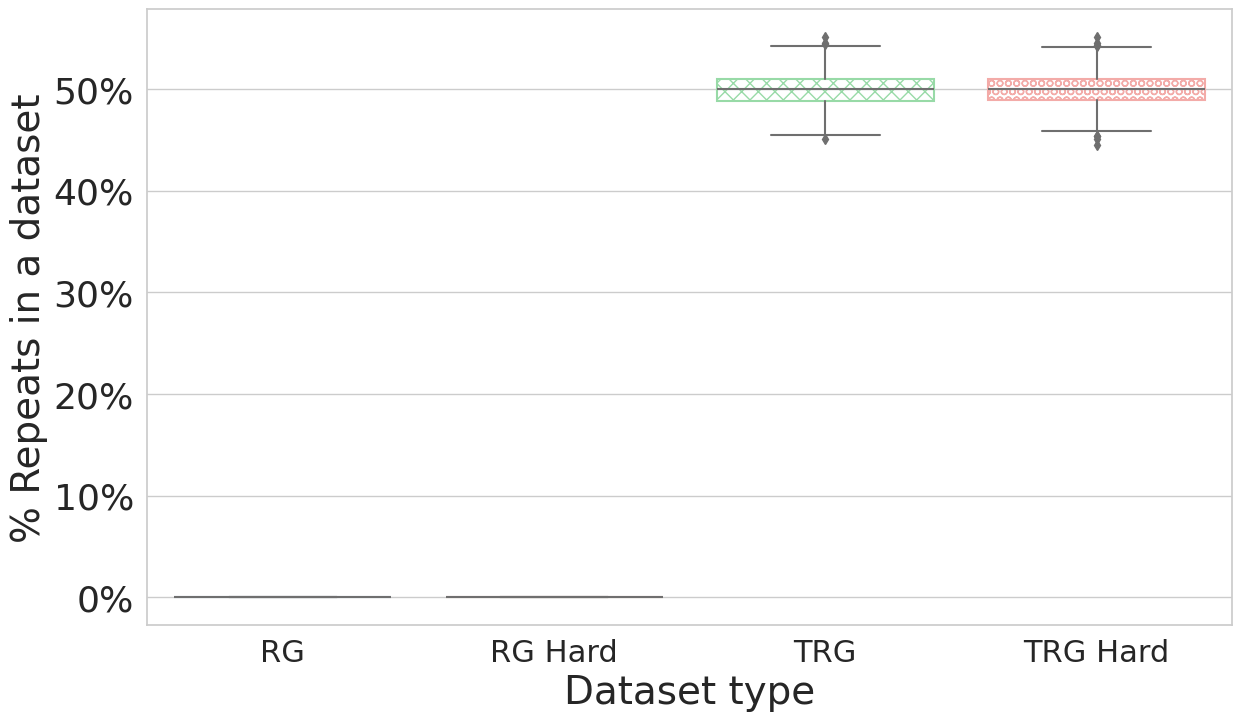

In [6]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(
    data=pd.DataFrame(
        dict(zip(["rg_classic", "rg_hard", "trg_previous", "trg_hard"], master_cnt))
    ),
    ax=ax,
).set(
    xlabel="Dataset type",
    ylabel="% Repeats in a dataset",
    xticklabels=[
        "RG",
        "RG Hard",
        "TRG",
        "TRG Hard",
    ],
)
ax.yaxis.set_major_formatter(PercentFormatter())
hatches = ["//", "..", "xx", "OO"]
patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
# the number of patches should be evenly divisible by the number of hatches
h = hatches * (len(patches) // len(hatches))
# iterate through the patches for each subplot
for patch, hatch in zip(patches, h):
    patch.set_hatch(hatch)
    fc = patch.get_facecolor()
    patch.set_edgecolor(fc)
    patch.set_facecolor("none")
plt.savefig("repeats_per_dataset.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("repeats_per_dataset.png", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    fig, ax = plt.subplots(figsize=(16, 8))
    mathches_figx = data.explode("objects_referred_to")
    mathches_figx["objects_referred_to"] = mathches_figx["objects_referred_to"].astype(
        int
    )

    sns.boxplot(
        data=mathches_figx,
        y="objects_referred_to",
        x="game_type",
        hue=mathches_figx[["loss_temporal", "training_dataset"]].apply(tuple, axis=1),
        order=[
            "analysis_always_same",
            "analysis_never_same",
            "rg_classic",
            "rg_hard",
            "trg_previous",
            "trg_hard",
        ],
    ).set(
        xlabel="Validation Dataset",
        ylabel="No. of objects a message refers to",
        xticklabels=[
            "Always Same",
            "Never Same",
            "RG",
            "RG Hard",
            "TRG Hard",
            "TRG",
        ],
    )
    labels = label_list[i]
    hatches = ["//", "..", "xx", "OO", "\\\\", "**", "||", "--"]
    patches = [patch for patch in ax.patches if type(patch) == mpl.patches.PathPatch]
    # the number of patches should be evenly divisible by the number of hatches
    h = hatches * (len(patches) // len(hatches))
    # iterate through the patches for each subplot
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor("none")
    h, _ = ax.get_legend_handles_labels()
    l = ax.legend(
        h,
        labels,
        title="Network Type",
        ncols=2,
        bbox_to_anchor=(0.5, 1.45),
        loc="upper center",
        labelspacing=0.35,
        columnspacing=1,
        handletextpad=0.7,
    )
    for lp, hatch in zip(l.get_patches(), hatches):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")
    plt.savefig(f"message_object_count_{i}.pdf", bbox_inches="tight", pad_inches=0)
    plt.savefig(f"message_object_count_{i}.png", bbox_inches="tight", pad_inches=0)
    plt.show()

In [ ]:
matches_to_analyse = matches_df[
    (matches_df["game_type"] == "trg_previous")
    | (matches_df["game_type"] == "trg_hard")
    | (matches_df["game_type"] == "analysis_always_same")
]

prev_emergence_count = []
for horizon in range(8):
    prev_emergence_count_horizon = []
    for index in range(matches_to_analyse.shape[0]):
        if (
            np.count_nonzero(
                matches_to_analyse[f"prev_use_percentage_h{horizon+1}"][index] == 100
            )
            >= 1
        ):
            prev_emergence_count_horizon.append(
                {
                    "network_type": matches_to_analyse["net_temporal"][index],
                    "purely_temporal": matches_to_analyse["purely_temporal"][index],
                    "loss_present": matches_to_analyse["loss_temporal"][index],
                    "attention_sender": matches_to_analyse["attention_sender"][index],
                    "attention_receiver": matches_to_analyse["attention_receiver"][
                        index
                    ],
                    "emerged": 1,
                }
            )
        else:
            prev_emergence_count_horizon.append(
                {
                    "network_type": matches_to_analyse["net_temporal"][index],
                    "purely_temporal": matches_to_analyse["purely_temporal"][index],
                    "loss_present": matches_to_analyse["loss_temporal"][index],
                    "attention_sender": matches_to_analyse["attention_sender"][index],
                    "attention_receiver": matches_to_analyse["attention_receiver"][
                        index
                    ],
                    "emerged": 0,
                }
            )
    prev_emergence_count.append(prev_emergence_count_horizon)

In [ ]:
for horizon in range(1, 9):
    stats_df = pd.DataFrame(prev_emergence_count[horizon - 1])
    x = stats_df[
        (stats_df["network_type"] == True) & (stats_df["loss_present"] == True)
    ]["emerged"].to_numpy()
    y = stats_df[
        (stats_df["network_type"] == True) & (stats_df["loss_present"] == False)
    ]["emerged"].to_numpy()
    res = scipy.stats.ks_2samp(x, y)
    print(f"Horizon {horizon}: {res}")

In [ ]:
for horizon in range(1, 9):
    df = pd.DataFrame(prev_emergence_count[horizon - 1])
    df = df[(df["attention_sender"] == False) & (df["attention_receiver"] == False)]
    df = df.drop(["attention_sender", "attention_receiver"], axis=1)
    print(df.groupby(["network_type", "purely_temporal", "loss_present"]).mean())

In [ ]:
pd.set_option("display.width", 150)
pd.set_option("display.max_columns", 15)

In [ ]:
for horizon in range(1, 9):
    df = pd.DataFrame(prev_emergence_count[horizon - 1])
    df = df[(df["attention_sender"] == True) & (df["attention_receiver"] == True)]
    df = df.drop(["network_type", "purely_temporal"], axis=1)
    print(df.groupby(["loss_present"]).mean())

In [ ]:
matches_to_analyse = matches_df[
    (matches_df["game_type"] == "trg_previous")
    | (matches_df["game_type"] == "trg_hard")
    | (matches_df["game_type"] == "analysis_always_same")
]

hist = []
for horizon in range(8):
    hist_horizon = []
    for index in range(matches_to_analyse.shape[0]):
        hist_horizon.append(
            {
                "network_type": matches_to_analyse["net_temporal"][index],
                "purely_temporal": matches_to_analyse["purely_temporal"][index],
                "loss_present": matches_to_analyse["loss_temporal"][index],
                "attention_sender": matches_to_analyse["attention_sender"][index],
                "attention_receiver": matches_to_analyse["attention_receiver"][index],
                "counts": matches_to_analyse[f"prev_use_percentage_h{horizon+1}"][
                    index
                ],
            }
        )
    hist.append(hist_horizon)

In [ ]:
data_list_2 = [
    [False, False, False, False],
    [False, False, True, True],
    [False, False, False, True],
    [True, True, False, False],
]
label_list_2 = [
    [
        "Base",
        "Base+L",
    ],
    [
        "Temporal",
        "Temporal+L",
    ],
    [
        "TemporalR",
        "TemporalR+L",
    ],
    [
        "Attention",
        "Attention+L",
    ],
]

In [ ]:
for i, df in enumerate(data_list_2):
    fig, axes = plt.subplots(figsize=(20, 32), nrows=4, ncols=2)
    axes = axes.reshape(-1)
    for horizon in range(1, 9):
        df = pd.DataFrame(hist[horizon - 1])
        df = df[
            (df["attention_sender"] == data_list_2[i][0])
            & (df["attention_receiver"] == data_list_2[i][1])
            & (df["purely_temporal"] == data_list_2[i][2])
            & (df["network_type"] == data_list_2[i][3])
        ].explode("counts")
        sns.histplot(
            data=df,
            x="counts",
            hue=df[["network_type", "loss_present"]].apply(tuple, axis=1),
            stat="percent",
            binwidth=5,
            multiple="dodge",
            common_norm=False,
            ax=axes[horizon - 1],
        ).set(
            xlabel=f"$M_{{\ominus^{horizon}}}$",
            ylabel=f"% of all messages",
        )
        axes[horizon - 1].yaxis.set_major_formatter(PercentFormatter(xmax=100))
        axes[horizon - 1].xaxis.set_major_formatter(PercentFormatter(xmax=100))
        if horizon != 1:
            axes[horizon - 1].get_legend().remove()
        hatches = ["//", "..", "xx", "OO"]
        hatches = sorted(hatches, key=lambda x: str(x)[1])
        patches = [
            patch
            for patch in axes[horizon - 1].patches
            if type(patch) == mpl.patches.Rectangle
        ]
        # the number of patches should be evenly divisible by the number of hatches
        h = hatches * (len(patches) // len(hatches))
        # Reorder for histogram
        h = sorted(h, key=lambda x: str(x)[1])
        # iterate through the patches for each subplot
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            fc = patch.get_facecolor()
            patch.set_edgecolor(fc)
            patch.set_facecolor("none")

    labels = label_list_2[i]
    h = axes[0].get_legend().legend_handles
    l = axes[0].legend(
        h,
        labels,
        title="Network Type",
        ncols=4,
        bbox_to_anchor=(1.0, 1.3),
        loc="upper center",
        labelspacing=0.35,
        columnspacing=1,
        handletextpad=0.7,
    )
    for lp, hatch in zip(l.get_patches(), hatches[::-1]):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")

    plt.savefig(f"temporal_msg_histogram_h8_{i}.pdf", bbox_inches="tight", pad_inches=0)
    plt.savefig(f"temporal_msg_histogram_h8_{i}.png", bbox_inches="tight", pad_inches=0)
    plt.show()

In [ ]:
for i, df in enumerate(data_list_2):
    fig, axes = plt.subplots(figsize=(12, 8), nrows=1, ncols=1)
    # Single plot
    df = pd.DataFrame(hist[4])
    df = df[
        (df["attention_sender"] == data_list_2[i][0])
        & (df["attention_receiver"] == data_list_2[i][1])
        & (df["purely_temporal"] == data_list_2[i][2])
        & (df["network_type"] == data_list_2[i][3])
    ].explode("counts")
    sns.histplot(
        data=df,
        x="counts",
        hue=df[["network_type", "loss_present"]].apply(tuple, axis=1),
        stat="percent",
        binwidth=5,
        multiple="dodge",
        common_norm=False,
        ax=axes,
    ).set(
        xlabel=f"$M_{{\ominus^{4}}}$",
        ylabel=f"% of all messages",
    )
    axes.yaxis.set_major_formatter(PercentFormatter(xmax=100))
    axes.xaxis.set_major_formatter(PercentFormatter(xmax=100))
    hatches = ["//", "..", "xx", "OO"]
    hatches = sorted(hatches, key=lambda x: str(x)[1])
    patches = [patch for patch in axes.patches if type(patch) == mpl.patches.Rectangle]
    # the number of patches should be evenly divisible by the number of hatches
    h = hatches * (len(patches) // len(hatches))
    # Reorder for histogram
    h = sorted(h, key=lambda x: str(x)[1])
    # iterate through the patches for each subplot
    for patch, hatch in zip(patches, h):
        patch.set_hatch(hatch)
        fc = patch.get_facecolor()
        patch.set_edgecolor(fc)
        patch.set_facecolor("none")

    labels = label_list_2[i]
    h = axes.get_legend().legend_handles
    l = axes.legend(
        h,
        labels,
        title="Network Type",
        ncols=4,
        bbox_to_anchor=(0.5, 1.25),
        loc="upper center",
        labelspacing=0.35,
        columnspacing=1,
        handletextpad=0.7,
    )
    for lp, hatch in zip(l.get_patches(), hatches[::-1]):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")

    plt.savefig(
        f"temporal_msg_histogram_h4_{i}_s.pdf", bbox_inches="tight", pad_inches=0
    )
    plt.savefig(
        f"temporal_msg_histogram_h4_{i}_s.png", bbox_inches="tight", pad_inches=0
    )
    plt.show()

In [ ]:
label_list_3 = [
    [
        "Base",
        "Base+L",
    ],
    [
        "Temporal",
        "Temporal+L",
    ],
    [
        "TemporalR",
        "TemporalR+L",
    ],
    [
        "Attention",
        "Attention+L",
    ],
]

In [ ]:
for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    fig, axes = plt.subplots(figsize=(26, 32), nrows=4, ncols=2)
    axes = axes.reshape(-1)
    for horizon in range(1, 9):
        matches_df_fig6 = data.loc[
            (matches_df["game_type"] != "analysis_always_same")
            & (matches_df["game_type"] != "analysis_never_same")
        ].explode(f"prev_use_percentage_h{horizon}")
        matches_df_fig6 = matches_df_fig6.loc[
            (matches_df_fig6[f"prev_use_percentage_h{horizon}"] > 0.4)
        ]
        # Somehow this cannot be used directly here, but can be in other plots?
        # So have to convert to temporary index
        matches_df_fig6["temp_ind"] = matches_df_fig6[
            ["loss_temporal", "net_temporal"]
        ].apply(tuple, axis=1)
        matches_df_fig6 = matches_df_fig6.astype({"temp_ind": str})
        sns.boxplot(
            data=matches_df_fig6,
            y=f"prev_use_percentage_h{horizon}",
            x="temp_ind",
            hue="repeat_chance",
            ax=axes[horizon - 1],
            palette=palette[0:3],
        ).set(
            xlabel="Network Type",
            ylabel=f"$M_{{\ominus^{horizon}}}$",
            xticklabels=label_list_3[i],
        )
        axes[horizon - 1].yaxis.set_major_formatter(PercentFormatter(decimals=0))
        if horizon != 1:
            axes[horizon - 1].get_legend().remove()
        hatches = ["//", "..", "xx"]
        patches = [
            patch
            for patch in axes[horizon - 1].patches
            if type(patch) == mpl.patches.PathPatch
        ]
        # the number of patches should be evenly divisible by the number of hatches
        h = hatches * (len(patches) // len(hatches))
        # iterate through the patches for each subplot
        for patch, hatch in zip(patches, h):
            patch.set_hatch(hatch)
            fc = patch.get_facecolor()
            patch.set_edgecolor(fc)
            patch.set_facecolor("none")

    h, _ = axes[horizon - 1].get_legend_handles_labels()
    labels = ["25%", "50%", "75%"]
    l = axes[0].legend(
        h,
        labels,
        title="Repeat Chance",
        ncols=3,
        bbox_to_anchor=(1.0, 1.25),
        loc="upper center",
    )
    for lp, hatch in zip(l.get_patches(), hatches):
        lp.set_hatch(hatch)
        fc = lp.get_facecolor()
        lp.set_edgecolor(fc)
        lp.set_facecolor("none")
    plt.savefig(
        f"temporality_vs_repeat_chance_h8_{i}.pdf", bbox_inches="tight", pad_inches=0
    )
    plt.savefig(
        f"temporality_vs_repeat_chance_h8_{i}.png", bbox_inches="tight", pad_inches=0
    )
    plt.show()

### Re-create graph from wandb

In [ ]:
runs_full_df_repl = pd.read_pickle("./data/v4/runs_full_df.pickle")
runs_full_df_repl = runs_full_df_repl[["summary", "config", "name"]]

repl = []

for i in range(len(runs_full_df_repl)):
    new_df = runs_full_df_repl["summary"][i][["epoch", "val_acc"]].assign(
        run_id=runs_full_df_repl["name"][i],
        temporal=runs_full_df_repl["config"][i]["temporal"],
        loss_temporal=runs_full_df_repl["config"][i]["temporal_loss"],
        attention_sender=runs_full_df_repl["config"][i]["attention_sender"],
        attention_receiver=runs_full_df_repl["config"][i]["attention_receiver"],
        vocab_size=runs_full_df_repl["config"][i]["vocab_size"],
        prev_horizon=runs_full_df_repl["config"][i]["prev_horizon"],
        repeat_chance=runs_full_df_repl["config"][i]["repeat_chance"],
        length_penalty=runs_full_df_repl["config"][i]["length_penalty"],
        message_length=runs_full_df_repl["config"][i]["message_length"],
        purely_temporal=runs_full_df_repl["config"][i]["purely_temporal"],
        training_dataset="",
    )
    repl.append(new_df)

repl = pd.concat(repl, axis=0, ignore_index=True)
for match in tqdm(matches):
    repl.loc[repl["run_id"] == matches[match]["run_id"], "training_dataset"] = matches[
        match
    ]["training_dataset"]

repl = repl.replace(r"^s*$", float("NaN"), regex=True).dropna()
repl = repl.sort_values(["loss_temporal", "temporal", "training_dataset"])

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.lineplot(
    data=repl[
        (repl["attention_sender"] == False) & (repl["attention_receiver"] == False)
    ],
    x="epoch",
    y="val_acc",
    hue=repl[["temporal", "loss_temporal"]].apply(tuple, axis=1),
    linewidth=1.5,
    palette=sns.color_palette("pastel"),
    ax=ax,
).set(
    xlabel="Epoch",
    ylabel="Accuracy",
)
labels = [
    "Temporal",
    "Non-Temporal",
    "Non-Temporal-NL",
    "Temporal-NL",
]
h, _ = ax.get_legend_handles_labels()
l = ax.legend(
    h,
    labels,
)
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=0))
plt.savefig("accuracy_vs_epoch_per_net_noat.pdf", bbox_inches="tight")
plt.savefig("accuracy_vs_epoch_per_net_noat.png", bbox_inches="tight")
plt.show()

## Statistical Analysis

In [ ]:
stats = defaultdict(lambda: defaultdict(dict))

### Accuracy

In [ ]:
labels = ["Base", "Temporal", "TemporalR", "Attention"]

for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    for game_type in [
        "analysis_always_same",
        "analysis_never_same",
        "rg_classic",
        "rg_hard",
        "trg_previous",
        "trg_hard",
    ]:
        print(f"Checking {labels[i]}, on eval {game_type}")
        datum = data[(data["game_type"] == game_type)]
        d1 = datum[
            (datum["loss_temporal"] == True)
            & (datum["training_dataset"] == "train_regular")
        ]
        d2 = datum[
            (datum["loss_temporal"] == False)
            & (datum["training_dataset"] == "train_regular")
        ]
        d3 = datum[
            (datum["loss_temporal"] == True)
            & (datum["training_dataset"] == "train_temporal")
        ]
        d4 = datum[
            (datum["loss_temporal"] == False)
            & (datum["training_dataset"] == "train_temporal")
        ]
        # Normality tests
        stats[labels[i]][game_type]["acc_l_rg_normal_p_val"] = scipy.stats.normaltest(
            list(d1["object_accuracy"])
        )[1]
        stats[labels[i]][game_type]["acc_nl_rg_normal_p_val"] = scipy.stats.normaltest(
            list(d2["object_accuracy"])
        )[1]
        stats[labels[i]][game_type]["acc_l_trg_normal_p_val"] = scipy.stats.normaltest(
            list(d3["object_accuracy"])
        )[1]
        stats[labels[i]][game_type]["acc_nl_trg_normal_p_val"] = scipy.stats.normaltest(
            list(d4["object_accuracy"])
        )[1]
        # Distribution tests
        stats[labels[i]][game_type]["acc_kruskal_p_val"] = scipy.stats.kruskal(
            d1["object_accuracy"],
            d2["object_accuracy"],
            d3["object_accuracy"],
            d4["object_accuracy"],
        )[1]
        stats[labels[i]][game_type]["acc_conover_df"] = sp.posthoc_conover(
            a=[
                d1["object_accuracy"],
                d2["object_accuracy"],
                d3["object_accuracy"],
                d4["object_accuracy"],
            ],
            p_adjust="holm",
        )
        mapping = {
            1: f"{labels[i]}+L RG",
            2: f"{labels[i]} RG",
            3: f"{labels[i]}+L TRG",
            4: f"{labels[i]} RG",
        }
        stats[labels[i]][game_type]["acc_conover_df"] = stats[labels[i]][game_type][
            "acc_conover_df"
        ].rename(columns=mapping, index=mapping)
        # Means
        stats[labels[i]][game_type]["acc_l_rg_mean"] = d1["object_accuracy"].mean()
        stats[labels[i]][game_type]["acc_nl_rg_mean"] = d2["object_accuracy"].mean()
        stats[labels[i]][game_type]["acc_l_trg_mean"] = d3["object_accuracy"].mean()
        stats[labels[i]][game_type]["acc_nl_trg_mean"] = d4["object_accuracy"].mean()
        # Min
        stats[labels[i]][game_type]["acc_l_rg_min"] = d1["object_accuracy"].min()
        stats[labels[i]][game_type]["acc_nl_rg_min"] = d2["object_accuracy"].min()
        stats[labels[i]][game_type]["acc_l_trg_min"] = d3["object_accuracy"].min()
        stats[labels[i]][game_type]["acc_nl_trg_min"] = d4["object_accuracy"].min()
        # Max
        stats[labels[i]][game_type]["acc_l_rg_max"] = d1["object_accuracy"].max()
        stats[labels[i]][game_type]["acc_nl_rg_max"] = d2["object_accuracy"].max()
        stats[labels[i]][game_type]["acc_l_trg_max"] = d3["object_accuracy"].max()
        stats[labels[i]][game_type]["acc_nl_trg_max"] = d4["object_accuracy"].max()
        # STD
        stats[labels[i]][game_type]["acc_l_rg_std"] = d1["object_accuracy"].std()
        stats[labels[i]][game_type]["acc_nl_rg_std"] = d2["object_accuracy"].std()
        stats[labels[i]][game_type]["acc_l_trg_std"] = d3["object_accuracy"].std()
        stats[labels[i]][game_type]["acc_nl_trg_std"] = d4["object_accuracy"].std()

### Temporality

In [ ]:
labels = ["Base", "Temporal", "TemporalR", "Attention"]

for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    # We skip never same here, as it makes no sense to test for it
    for game_type in [
        "analysis_always_same",
        "rg_classic",
        "rg_hard",
        "trg_previous",
        "trg_hard",
    ]:
        print(f"Checking {labels[i]}, on eval {game_type}:")
        datum = data[
            (data["game_type"] == game_type) & (matches_df["repeat_chance"] == 50)
        ]
        for j in range(1, 9):
            datum_h = datum[
                ["loss_temporal", f"prev_use_percentage_h{j}", "training_dataset"]
            ].explode(f"prev_use_percentage_h{j}")
            d1 = datum_h[
                (datum_h["loss_temporal"] == True)
                & (datum_h["training_dataset"] == "train_regular")
            ]
            d2 = datum_h[
                (datum_h["loss_temporal"] == False)
                & (datum_h["training_dataset"] == "train_regular")
            ]
            d3 = datum_h[
                (datum_h["loss_temporal"] == True)
                & (datum_h["training_dataset"] == "train_temporal")
            ]
            d4 = datum_h[
                (datum_h["loss_temporal"] == False)
                & (datum_h["training_dataset"] == "train_temporal")
            ]
            # Normality tests
            stats[labels[i]][game_type][
                f"temporality_h{j}_l_rg_normal_p_val"
            ] = scipy.stats.normaltest(list(d1[f"prev_use_percentage_h{j}"]))[1]
            stats[labels[i]][game_type][
                f"temporality_h{j}_nl_rg_normal_p_val"
            ] = scipy.stats.normaltest(list(d2[f"prev_use_percentage_h{j}"]))[1]
            stats[labels[i]][game_type][
                f"temporality_h{j}_l_trg_normal_p_val"
            ] = scipy.stats.normaltest(list(d3[f"prev_use_percentage_h{j}"]))[1]
            stats[labels[i]][game_type][
                f"temporality_h{j}_nl_trg_normal_p_val"
            ] = scipy.stats.normaltest(list(d4[f"prev_use_percentage_h{j}"]))[1]
            # Distribution tests
            try:
                stats[labels[i]][game_type][
                    f"temporality_h{j}_kruskal_p_val"
                ] = scipy.stats.kruskal(
                    d1[f"prev_use_percentage_h{j}"],
                    d2[f"prev_use_percentage_h{j}"],
                    d3[f"prev_use_percentage_h{j}"],
                    d4[f"prev_use_percentage_h{j}"],
                )[
                    1
                ]
                stats[labels[i]][game_type][
                    f"temporality_h{j}_conover_df"
                ] = sp.posthoc_conover(
                    a=[
                        d1[f"prev_use_percentage_h{j}"],
                        d2[f"prev_use_percentage_h{j}"],
                        d3[f"prev_use_percentage_h{j}"],
                        d4[f"prev_use_percentage_h{j}"],
                    ],
                    p_adjust="holm",
                )
                mapping = {
                    1: f"{labels[i]}+L RG",
                    2: f"{labels[i]} RG",
                    3: f"{labels[i]}+L TRG",
                    4: f"{labels[i]} RG",
                }
                stats[labels[i]][game_type][f"temporality_h{j}_conover_df"] = stats[
                    labels[i]
                ][game_type][f"temporality_h{j}_conover_df"].rename(
                    columns=mapping, index=mapping
                )
            except ValueError as e:
                print(e)
                print("Continuing")
                continue
            # Means
            stats[labels[i]][game_type][f"temporality_h{j}_l_rg_mean"] = d1[
                f"prev_use_percentage_h{j}"
            ].mean()
            stats[labels[i]][game_type][f"temporality_h{j}_nl_rg_mean"] = d2[
                f"prev_use_percentage_h{j}"
            ].mean()
            stats[labels[i]][game_type][f"temporality_h{j}_l_trg_mean"] = d3[
                f"prev_use_percentage_h{j}"
            ].mean()
            stats[labels[i]][game_type][f"temporality_h{j}_nl_trg_mean"] = d4[
                f"prev_use_percentage_h{j}"
            ].mean()
            # Min
            stats[labels[i]][game_type][f"temporality_h{j}_l_rg_min"] = d1[
                f"prev_use_percentage_h{j}"
            ].min()
            stats[labels[i]][game_type][f"temporality_h{j}_nl_rg_min"] = d2[
                f"prev_use_percentage_h{j}"
            ].min()
            stats[labels[i]][game_type][f"temporality_h{j}_l_trg_min"] = d3[
                f"prev_use_percentage_h{j}"
            ].min()
            stats[labels[i]][game_type][f"temporality_h{j}_nl_trg_min"] = d4[
                f"prev_use_percentage_h{j}"
            ].min()
            # Max
            stats[labels[i]][game_type][f"temporality_h{j}_l_rg_max"] = d1[
                f"prev_use_percentage_h{j}"
            ].max()
            stats[labels[i]][game_type][f"temporality_h{j}_nl_rg_max"] = d2[
                f"prev_use_percentage_h{j}"
            ].max()
            stats[labels[i]][game_type][f"temporality_h{j}_l_trg_max"] = d3[
                f"prev_use_percentage_h{j}"
            ].max()
            stats[labels[i]][game_type][f"temporality_h{j}_nl_trg_max"] = d4[
                f"prev_use_percentage_h{j}"
            ].max()
            # STD
            stats[labels[i]][game_type][f"temporality_h{j}_l_rg_std"] = d1[
                f"prev_use_percentage_h{j}"
            ].std()
            stats[labels[i]][game_type][f"temporality_h{j}_nl_rg_std"] = d2[
                f"prev_use_percentage_h{j}"
            ].std()
            stats[labels[i]][game_type][f"temporality_h{j}_l_trg_std"] = d3[
                f"prev_use_percentage_h{j}"
            ].std()
            stats[labels[i]][game_type][f"temporality_h{j}_nl_trg_std"] = d4[
                f"prev_use_percentage_h{j}"
            ].std()

### Compositionality

In [ ]:
labels = ["Base", "Temporal", "TemporalR", "Attention"]

for i, data in enumerate([base_data, temporal_data, temporalr_data, attention_data]):
    for compos_metric in ["topsim", "posdis", "bosdis"]:
        print(f"Checking {labels[i]}, on metric {compos_metric}")
        datum = data
        d1 = datum[
            (datum["loss_temporal"] == True)
            & (datum["training_dataset"] == "train_regular")
        ]
        d2 = datum[
            (datum["loss_temporal"] == False)
            & (datum["training_dataset"] == "train_regular")
        ]
        d3 = datum[
            (datum["loss_temporal"] == True)
            & (datum["training_dataset"] == "train_temporal")
        ]
        d4 = datum[
            (datum["loss_temporal"] == False)
            & (datum["training_dataset"] == "train_temporal")
        ]
        # Normality tests
        stats[labels[i]][game_type][
            f"{compos_metric}_l_rg_normal_p_val"
        ] = scipy.stats.normaltest(list(d1[compos_metric]))[1]
        stats[labels[i]][game_type][
            f"{compos_metric}_nl_rg_normal_p_val"
        ] = scipy.stats.normaltest(list(d2[compos_metric]))[1]
        stats[labels[i]][game_type][
            f"{compos_metric}_l_trg_normal_p_val"
        ] = scipy.stats.normaltest(list(d3[compos_metric]))[1]
        stats[labels[i]][game_type][
            f"{compos_metric}_nl_trg_normal_p_val"
        ] = scipy.stats.normaltest(list(d4[compos_metric]))[1]
        # Distribution tests
        stats[labels[i]][game_type][
            f"{compos_metric}_kruskal_p_val"
        ] = scipy.stats.kruskal(
            d1[compos_metric], d2[compos_metric], d3[compos_metric], d4[compos_metric]
        )[
            1
        ]
        stats[labels[i]][game_type][f"{compos_metric}_conover_df"] = sp.posthoc_conover(
            a=[
                d1[compos_metric],
                d2[compos_metric],
                d3[compos_metric],
                d4[compos_metric],
            ],
            p_adjust="holm",
        )
        mapping = {
            1: f"{labels[i]}+L RG",
            2: f"{labels[i]} RG",
            3: f"{labels[i]}+L TRG",
            4: f"{labels[i]} RG",
        }
        stats[labels[i]][game_type][f"{compos_metric}_conover_df"] = stats[labels[i]][
            game_type
        ][f"{compos_metric}_conover_df"].rename(columns=mapping, index=mapping)
        # Means
        stats[labels[i]][game_type][f"{compos_metric}_l_rg_mean"] = d1[
            compos_metric
        ].mean()
        stats[labels[i]][game_type][f"{compos_metric}_nl_rg_mean"] = d2[
            compos_metric
        ].mean()
        stats[labels[i]][game_type][f"{compos_metric}_l_trg_mean"] = d3[
            compos_metric
        ].mean()
        stats[labels[i]][game_type][f"{compos_metric}_nl_trg_mean"] = d4[
            compos_metric
        ].mean()
        # Min
        stats[labels[i]][game_type][f"{compos_metric}_l_rg_min"] = d1[
            compos_metric
        ].min()
        stats[labels[i]][game_type][f"{compos_metric}_nl_rg_min"] = d2[
            compos_metric
        ].min()
        stats[labels[i]][game_type][f"{compos_metric}_l_trg_min"] = d3[
            compos_metric
        ].min()
        stats[labels[i]][game_type][f"{compos_metric}_nl_trg_min"] = d4[
            compos_metric
        ].min()
        # Max
        stats[labels[i]][game_type][f"{compos_metric}_l_rg_max"] = d1[
            compos_metric
        ].max()
        stats[labels[i]][game_type][f"{compos_metric}_nl_rg_max"] = d2[
            compos_metric
        ].max()
        stats[labels[i]][game_type][f"{compos_metric}_l_trg_max"] = d3[
            compos_metric
        ].max()
        stats[labels[i]][game_type][f"{compos_metric}_nl_trg_max"] = d4[
            compos_metric
        ].max()
        # STD
        stats[labels[i]][game_type][f"{compos_metric}_l_rg_std"] = d1[
            compos_metric
        ].std()
        stats[labels[i]][game_type][f"{compos_metric}_nl_rg_std"] = d2[
            compos_metric
        ].std()
        stats[labels[i]][game_type][f"{compos_metric}_l_trg_std"] = d3[
            compos_metric
        ].std()
        stats[labels[i]][game_type][f"{compos_metric}_nl_trg_std"] = d4[
            compos_metric
        ].std()

### Comparisons across network types

#### Accuracy

In [ ]:
stats_network = defaultdict(lambda: defaultdict(dict))

In [ ]:
for game_type in [
    "analysis_always_same",
    "analysis_never_same",
    "rg_classic",
    "rg_hard",
    "trg_previous",
    "trg_hard",
]:
    print(f"Checking all types on eval {game_type}:")
    d1 = list(base_data[(base_data["game_type"] == game_type)]["object_accuracy"])
    d2 = list(
        temporal_data[(temporal_data["game_type"] == game_type)]["object_accuracy"]
    )
    d3 = list(
        temporalr_data[(temporalr_data["game_type"] == game_type)]["object_accuracy"]
    )
    d4 = list(
        attention_data[(attention_data["game_type"] == game_type)]["object_accuracy"]
    )
    print(scipy.stats.kruskal(d1, d2, d3, d4))
    res = sp.posthoc_conover(a=[d1, d2, d3, d4], p_adjust="holm")
    mapping = {1: "Base", 2: "Temporal", 3: "TemporalR", 4: "Attention"}
    res = res.rename(columns=mapping, index=mapping)
    stats_network[game_type]["acc"] = res
    print(res)

#### Temporality

In [ ]:
# We skip never same here, as it makes no sense to test for it
for game_type in [
    "analysis_always_same",
    "rg_classic",
    "rg_hard",
    "trg_previous",
    "trg_hard",
]:
    for j in range(1, 9):
        print(f"Testing {game_type} with h={j}")
        d1 = list(
            base_data[(base_data["game_type"] == game_type)].explode(
                f"prev_use_percentage_h{j}"
            )[f"prev_use_percentage_h{j}"]
        )
        d2 = list(
            temporal_data[(temporal_data["game_type"] == game_type)].explode(
                f"prev_use_percentage_h{j}"
            )[f"prev_use_percentage_h{j}"]
        )
        d3 = list(
            temporalr_data[(temporalr_data["game_type"] == game_type)].explode(
                f"prev_use_percentage_h{j}"
            )[f"prev_use_percentage_h{j}"]
        )
        d4 = list(
            attention_data[(attention_data["game_type"] == game_type)].explode(
                f"prev_use_percentage_h{j}"
            )[f"prev_use_percentage_h{j}"]
        )
        if (
            len(set(d1)) == 1
            and len(set(d2)) == 1
            and len(set(d3)) == 1
            and len(set(d4)) == 1
        ):
            print(f"Skipping {j}")
            continue
        print(scipy.stats.kruskal(d1, d2, d3, d4))
        res = sp.posthoc_conover(a=[d1, d2, d3, d4], p_adjust="holm")
        mapping = {1: "Base", 2: "Temporal", 3: "TemporalR", 4: "Attention"}
        res = res.rename(columns=mapping, index=mapping)
        stats_network[game_type][f"temporality_h{j}"] = res
        print(res)

#### Compositionality

In [ ]:
for compos_metric in ["topsim", "posdis", "bosdis"]:
    print(f"Checking all types on {compos_metric}:")
    d1 = list(base_data[(base_data["game_type"] == game_type)][compos_metric])
    d2 = list(temporal_data[(temporal_data["game_type"] == game_type)][compos_metric])
    d3 = list(temporalr_data[(temporalr_data["game_type"] == game_type)][compos_metric])
    d4 = list(attention_data[(attention_data["game_type"] == game_type)][compos_metric])
    print(scipy.stats.kruskal(d1, d2, d3, d4))
    res = sp.posthoc_conover(a=[d1, d2, d3, d4], p_adjust="holm")
    mapping = {1: "Base", 2: "Temporal", 3: "TemporalR", 4: "Attention"}
    res = res.rename(columns=mapping, index=mapping)
    stats_network[game_type][compos_metric] = res
    print(res)

In [ ]:
pd.DataFrame(stats).to_pickle("stats.pickle")
pd.DataFrame(stats_network).to_pickle("stats_network.pickle")

In [ ]:
stats_df = pd.read_pickle("stats.pickle")
stats_network_df = pd.read_pickle("stats_network.pickle")

#### Latex Conversions

In [ ]:
for env in [
    "analysis_always_same",
    # "analysis_never_same",
    # "rg_classic",
    # "rg_hard",
    "trg_previous",
    "trg_hard",
]:
    for i in range(1, 9):
        print(f"{env}, h={i}")
        print(stats_network_df.T[f"temporality_h{i}"][env].to_latex())

In [ ]:
list_p = []
for net in ["Base", "Temporal", "TemporalR", "Attention"]:
    list_p_net = []
    for env in [
        "analysis_always_same",
        "analysis_never_same",
        "rg_classic",
        "rg_hard",
        "trg_previous",
        "trg_hard",
    ]:
        list_p_net.append(stats[net][env]["acc_kruskal_p_val"])
    list_p.append(list_p_net)

print(
    pd.DataFrame(
        list_p,
        index=["Base", "Temporal", "TemporalR", "Attention"],
        columns=[
            "Always Same",
            "Never Same",
            "RG",
            "RG Hard",
            "TRG",
            "TRG Hard",
        ],
    ).to_latex()
)

In [ ]:
list_p = []
for net in ["Base", "Temporal", "TemporalR", "Attention"]:
    list_p_net = []
    for env in [
        "analysis_always_same",
        "analysis_never_same",
        "rg_classic",
        "rg_hard",
        "trg_previous",
        "trg_hard",
    ]:
        list_p_net.append(stats[net][env]["acc_conover_df"])
    list_p.append(list_p_net)

for i, net in enumerate(["Base", "Temporal", "TemporalR", "Attention"]):
    print(f"Network {net}")
    for x in list_p[i]:
        print(x.to_latex())

In [ ]:
list_p = []
for net in ["Base", "Temporal", "TemporalR", "Attention"]:
    list_p_net = []
    for env in [
        "analysis_always_same",
        "analysis_never_same",
        "rg_classic",
        "rg_hard",
        "trg_previous",
        "trg_hard",
    ]:
        list_p_net.append(stats[net][env]["acc_conover_df"])
    list_p.append(list_p_net)

for i, net in enumerate(["Base", "Temporal", "TemporalR", "Attention"]):
    print(f"Network {net}")
    for x in list_p[i]:
        print(x.to_latex())

In [ ]:
for i, net in enumerate(["Base", "Temporal", "TemporalR", "Attention"]):
    print(f"Network {net}")
    print(stats[net]["trg_hard"]["bosdis_conover_df"].to_latex())

In [ ]:
for horizon in range(1, 9):
    list_p = []
    for net in ["Temporal", "TemporalR", "Attention"]:
        list_p_net = []
        for env in [
            "analysis_always_same",
            # "analysis_never_same",
            # "rg_classic",
            # "rg_hard",
            "trg_previous",
            "trg_hard",
        ]:
            list_p_net.append(stats[net][env][f"temporality_h{horizon}_kruskal_p_val"])
        list_p.append(list_p_net)

    print(f"h={horizon}")
    print(
        pd.DataFrame(
            list_p,
            index=["Temporal", "TemporalR", "Attention"],
            columns=[
                "Always Same",
                "TRG",
                "TRG Hard",
            ],
        ).to_latex()
    )

In [ ]:
for horizon in range(1, 9):
    list_p = []
    for net in ["Temporal", "TemporalR", "Attention"]:
        list_p_net = []
        for env in [
            "analysis_always_same",
            # "analysis_never_same",
            # "rg_classic",
            # "rg_hard",
            "trg_previous",
            "trg_hard",
        ]:
            list_p_net.append(stats[net][env][f"temporality_h{horizon}_conover_df"])
        list_p.append(list_p_net)

    print(f"h={horizon}")
    for i, net in enumerate(["Temporal", "TemporalR", "Attention"]):
        print(f"Network {net}")
        for x in list_p[i]:
            print(x.to_latex())

## Miscellaneous visualisations

### Gumbel Softmax Visualisation

In [ ]:
import string

import torch

from trgl.utils.gumbel_softmax import gumbel_softmax_sample

sns.barplot(
    x=list(string.ascii_uppercase)[:6],
    y=gumbel_softmax_sample(torch.rand(6), temperature=1.0).numpy(),
)
# plt.xticks([])
# plt.yticks([])
plt.savefig("gs.pdf", bbox_inches="tight", pad_inches=0, transparent=True)
plt.show